In [1]:
import numpy as np
import random
from copy import deepcopy
from docplex.mp.model import Model
from matplotlib import pyplot as plt
import pandas as pd
from time import perf_counter

In [2]:
def is_feasible(solution, A, b):
    return np.all(np.dot(A, solution) <= b)

In [3]:
def initialize(n, A, b):
    solution = random.choices([1,0], k=n)
    while is_feasible(solution, A, b) == False:
        solution = random.choices([1,0], k=n)
    return solution

In [4]:
def calc_fitness(solution, c):
    return np.dot(c, solution)  

In [5]:
def make_small_change(solution, A, b):
    num_changes = max(1, random.randrange(0, max(1, len(solution) // 5)))
    indices = random.sample(range(len(solution)), num_changes)
    for j in indices:
        solution[j] = 1 - solution[j]

    return solution

In [6]:
def make_one_change(solution, A, b):
    indice = random.randrange(0, max(1, len(solution)))
    solution[indice] = 1 - solution[indice]

    return solution

In [51]:
# Simulated Annealing
def simulated_annealing(A, b, c, initial_solution=None, max_iter=40000, plot=True, func=1, initial_temp=1000, min_temp=10, cooling_rate=0.999):
    n = len(c)

    if initial_solution is None:
        solution = initialize(n, A, b)
    else:
        solution = initial_solution.copy()
    fitness = calc_fitness(solution, c)
    best_solution = solution.copy()
    best_fitness = fitness

    temperature = initial_temp
    fitnessess = []

    for _ in range(max_iter):
        if temperature <= min_temp:
            break
            
        new_solution = solution.copy()
        if func == 1:
            new_solution = make_small_change(new_solution, A, b)
        else:
            new_solution = make_one_change(new_solution, A, b)
        
        if is_feasible(new_solution, A, b):
            new_fitness = calc_fitness(new_solution, c)
            delta = new_fitness - fitness # - best_fitness ?

            if delta > 0 or random.random() < np.exp(delta / temperature):
                solution = new_solution.copy()
                fitness = new_fitness
                fitnessess.append(fitness)
                if new_fitness > best_fitness:
                    best_solution = new_solution.copy()
                    best_fitness = new_fitness
        
        temperature = max(min_temp, temperature * cooling_rate)

    if plot:
        plt.hist(fitnessess, bins=20, alpha=0.7)
        plt.title("SA")
        plt.xlabel("Fitness")
        plt.ylabel("Frequency")
        plt.show()
        
    return best_fitness, best_solution

In [36]:
def test(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    A = []
    for i, line in enumerate(lines):
        if i == 0:
            n, m, optimal_fitness = [int(x) for x in line.split()]
        elif i == 1:
            c = [int(x) for x in line.split()]
        elif i > 1 and i <= m+1:
            A.append([int(x) for x in line.split()])
        else:
            b = [int(x) for x in line.split()]

    return A, b, c, optimal_fitness

In [22]:
initial_temps = [50, 100, 300, 500, 750, 1000]
min_temps = [1, 5, 10, 15]

sa_temps_df = pd.DataFrame(columns=['inital_temp', 'min_temp'])

combination_num = 0
for initial_temp in initial_temps:
    for min_temp in min_temps:
        correct_num = 0
        sa_temps_df.loc[combination_num, 'inital_temp'] = initial_temp
        sa_temps_df.loc[combination_num, 'min_temp'] = min_temp
        for i in range(1, 21):
            A, b, c, optimal_fitness = test(file_path=f"../test_instances/test{i}.txt")
            sa_fitness, _ = simulated_annealing(A, b, c, plot=False, initial_temp=initial_temp, min_temp=min_temp)
            if sa_fitness == optimal_fitness:
                correct_num += 1
                sa_temps_df.loc[combination_num, f'sa managed to find an optimal solution for test{i}'] = 1
            else:
                sa_temps_df.loc[combination_num, f'sa managed to find an optimal solution for test{i}'] = 0
        sa_temps_df.loc[combination_num, f'number of optimal solutions'] = correct_num
        combination_num += 1

In [23]:
sa_temps_df

,inital_temp,min_temp,sa managed to find an optimal solution for test1,sa managed to find an optimal solution for test2,sa managed to find an optimal solution for test3,sa managed to find an optimal solution for test4,sa managed to find an optimal solution for test5,sa managed to find an optimal solution for test6,sa managed to find an optimal solution for test7,sa managed to find an optimal solution for test8,...,sa managed to find an optimal solution for test12,sa managed to find an optimal solution for test13,sa managed to find an optimal solution for test14,sa managed to find an optimal solution for test15,sa managed to find an optimal solution for test16,sa managed to find an optimal solution for test17,sa managed to find an optimal solution for test18,sa managed to find an optimal solution for test19,sa managed to find an optimal solution for test20,number of optimal_solutions
0,50,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0
1,50,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50,15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
5,100,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,100,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,100,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,300,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,300,5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [24]:
sa_temps_df.to_csv('sa_temps_df.csv')

In [48]:
sa_func_df = pd.DataFrame()

combination_num = 0
for j in range(1, 3):
    correct_num = 0
    for i in range(1, 21):
        A, b, c, optimal_fitness = test(file_path=f"../test_instances/test{i}.txt")
        sa_fitness, _ = simulated_annealing(A, b, c, func=j, plot=False)
        if j == 1:
            sa_func_df.loc[combination_num, 'func'] = 'small change'
        else:
            sa_func_df.loc[combination_num, 'func'] = 'one change'
            
        if sa_fitness == optimal_fitness:
            sa_func_df.loc[combination_num, f'sa managed to find an optimal solution for test{i}'] = 1
            correct_num += 1
        else:
            sa_func_df.loc[combination_num, f'sa managed to find an optimal solution for test{i}'] = 0
    sa_func_df.loc[combination_num, 'number of optimal solutions'] = correct_num
    combination_num += 1

In [49]:
sa_func_df

,func,sa managed to find an optimal solution for test1,sa managed to find an optimal solution for test2,sa managed to find an optimal solution for test3,sa managed to find an optimal solution for test4,sa managed to find an optimal solution for test5,sa managed to find an optimal solution for test6,sa managed to find an optimal solution for test7,sa managed to find an optimal solution for test8,sa managed to find an optimal solution for test9,...,sa managed to find an optimal solution for test12,sa managed to find an optimal solution for test13,sa managed to find an optimal solution for test14,sa managed to find an optimal solution for test15,sa managed to find an optimal solution for test16,sa managed to find an optimal solution for test17,sa managed to find an optimal solution for test18,sa managed to find an optimal solution for test19,sa managed to find an optimal solution for test20,number of optimal solutions
0,small change,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,one change,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [50]:
sa_func_df.to_csv('sa_func_df.csv')

Test 1:


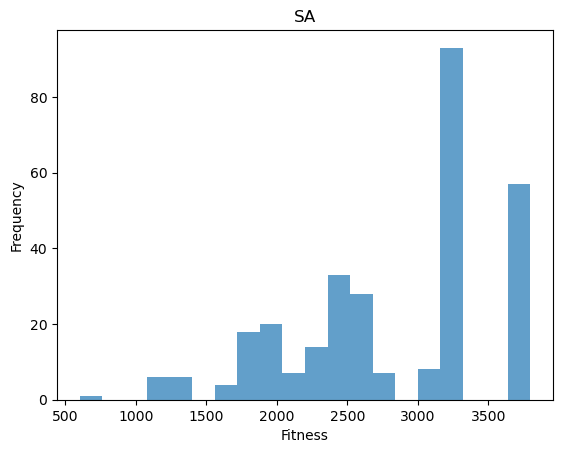

SA fitness: 3800
And it should be: 3800
SA solution:    [0, 1, 1, 0, 0, 1]
------------------------------
Test 2:


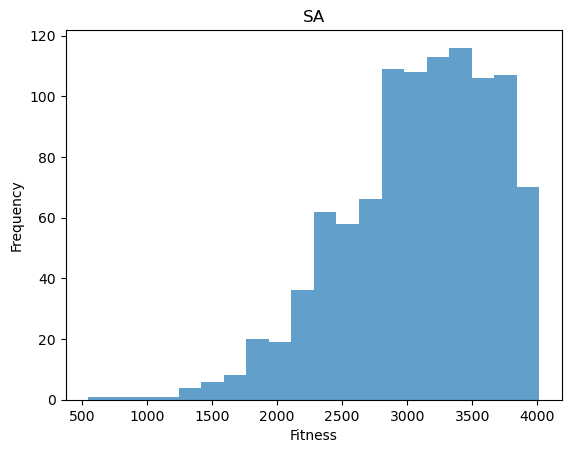

SA fitness: 4015
And it should be: 4015
SA solution:    [1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]
------------------------------
Test 3:


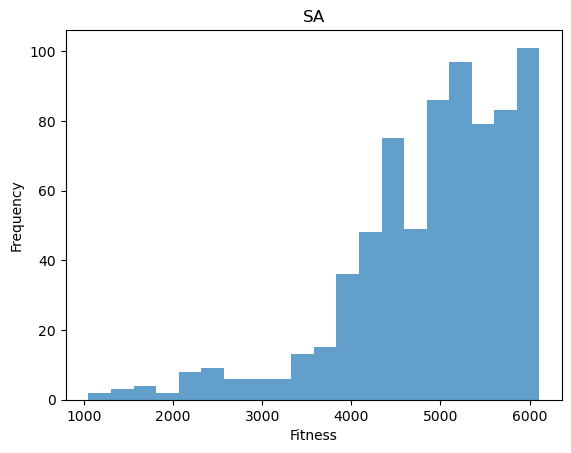

SA fitness: 6110
And it should be: 6120
SA solution:    [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]
------------------------------
Test 4:


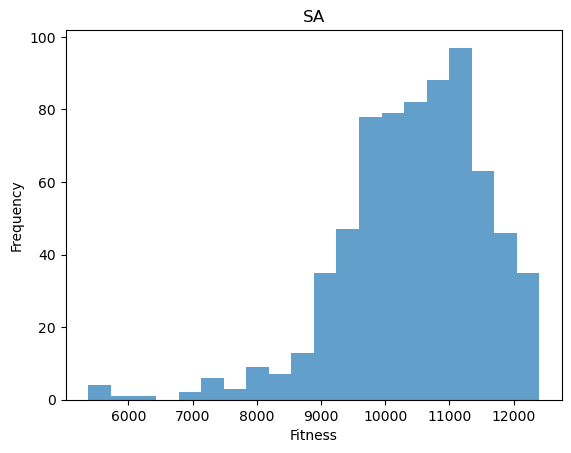

SA fitness: 12400
And it should be: 12400
SA solution:    [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
------------------------------
Test 5:


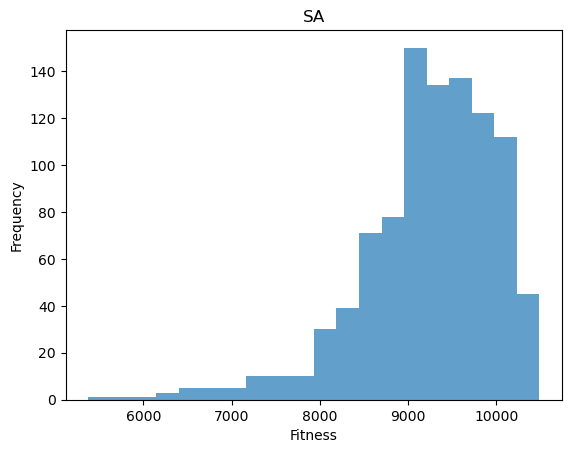

SA fitness: 10486
And it should be: 10618
SA solution:    [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
------------------------------
Test 6:


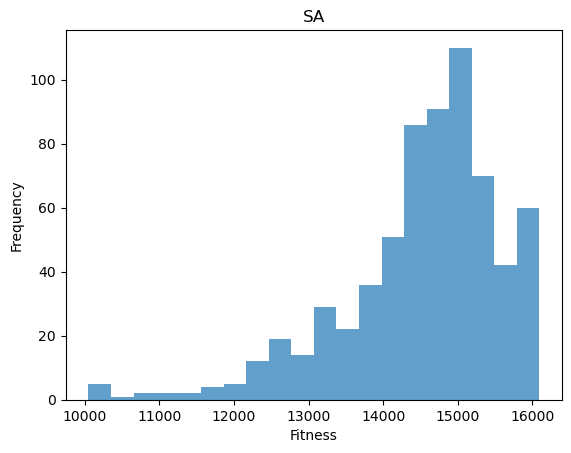

SA fitness: 16093
And it should be: 16537
SA solution:    [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
------------------------------
Test 7:


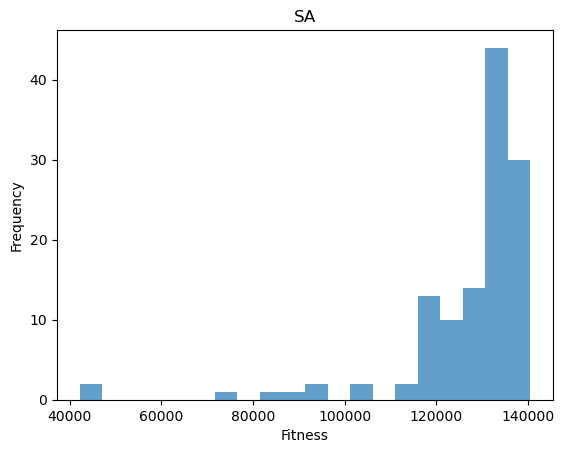

SA fitness: 140538
And it should be: 141278
SA solution:    [0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]
------------------------------
Test 8:


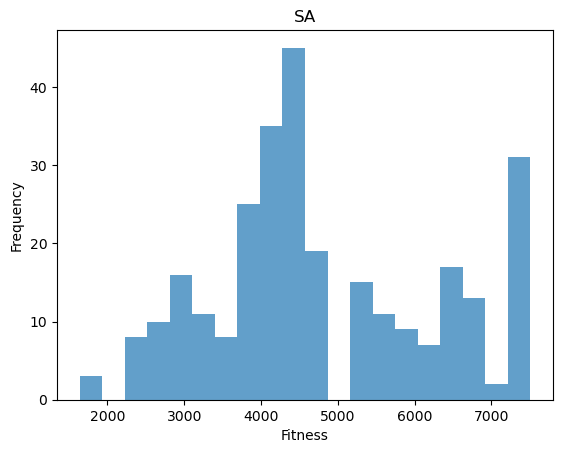

SA fitness: 7508
And it should be: 7772
SA solution:    [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
------------------------------
Test 9:


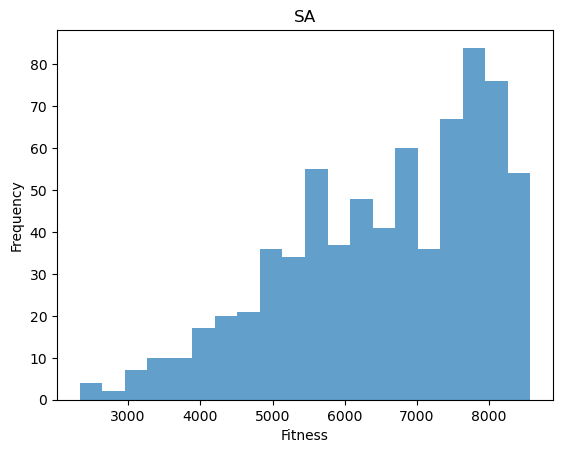

SA fitness: 8573
And it should be: 8722
SA solution:    [0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]
------------------------------
Test 10:


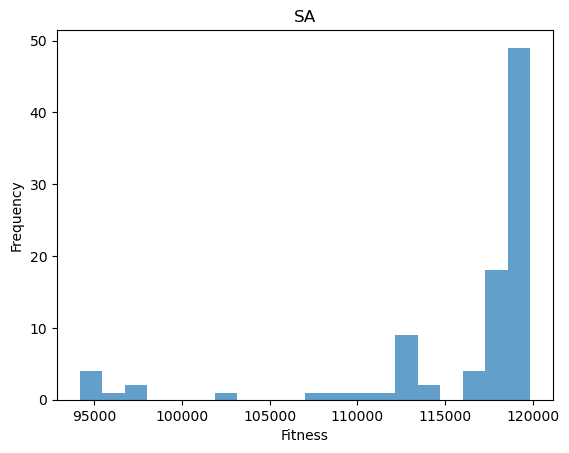

SA fitness: 119871
And it should be: 130883
SA solution:    [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]
------------------------------
Test 11:


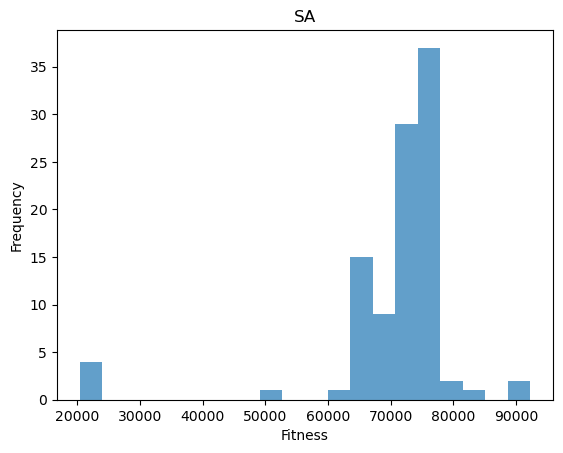

SA fitness: 92297
And it should be: 95677
SA solution:    [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
------------------------------
Test 12:


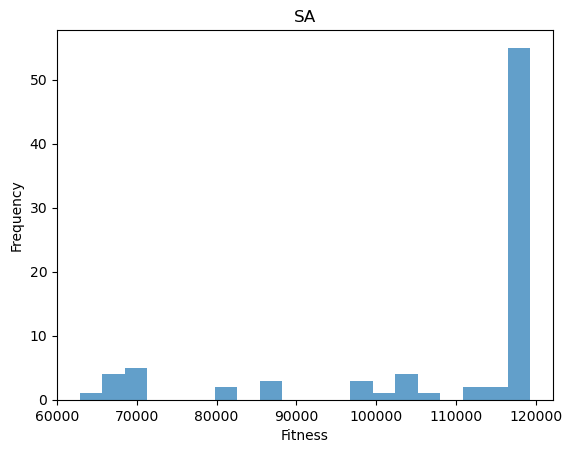

SA fitness: 119337
And it should be: 119337
SA solution:    [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]
------------------------------
Test 13:


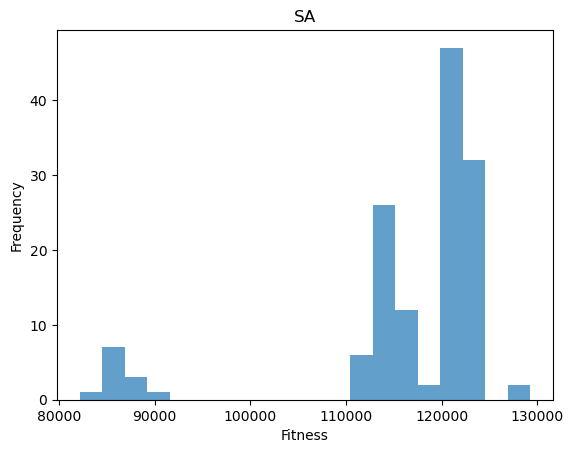

SA fitness: 129283
And it should be: 130623
SA solution:    [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]
------------------------------
Test 14:


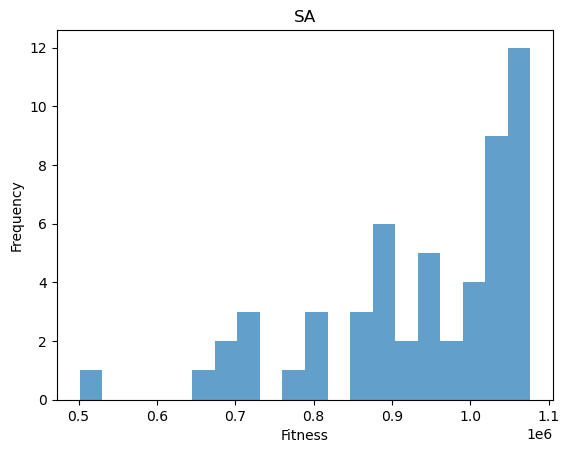

SA fitness: 1076771
And it should be: 1095445
SA solution:    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
------------------------------
Test 15:


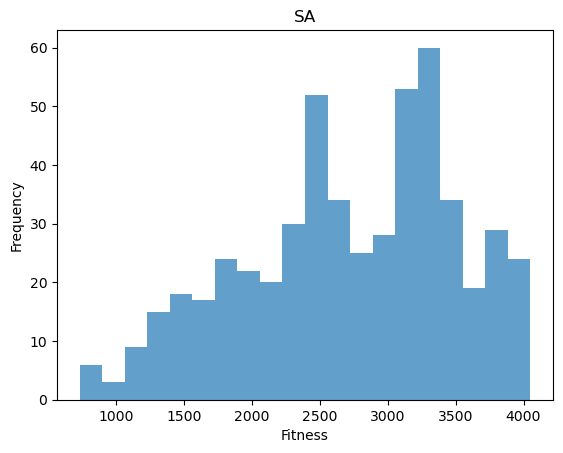

SA fitness: 4051
And it should be: 4115
SA solution:    [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]
------------------------------
Test 16:


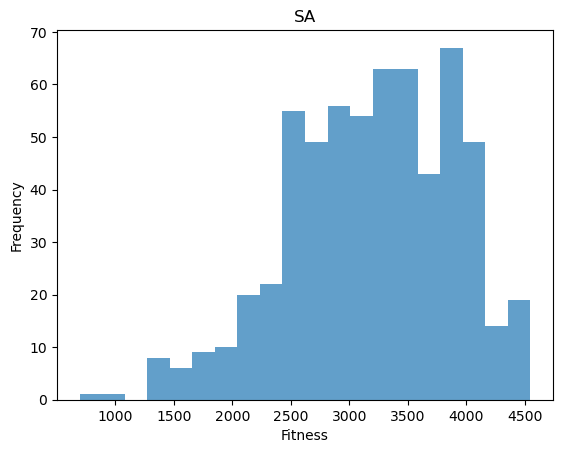

SA fitness: 4549
And it should be: 4554
SA solution:    [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
------------------------------
Test 17:


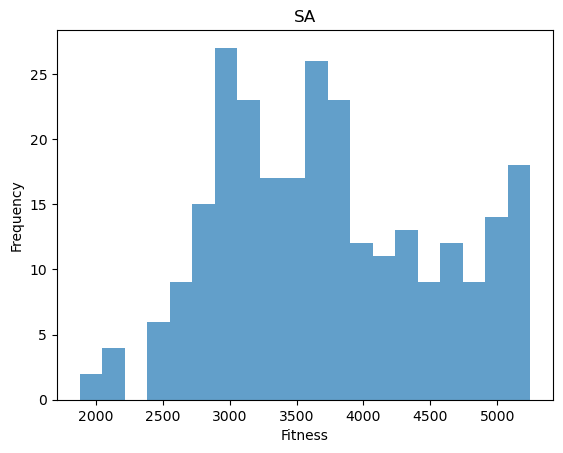

SA fitness: 5248
And it should be: 5643
SA solution:    [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]
------------------------------
Test 18:


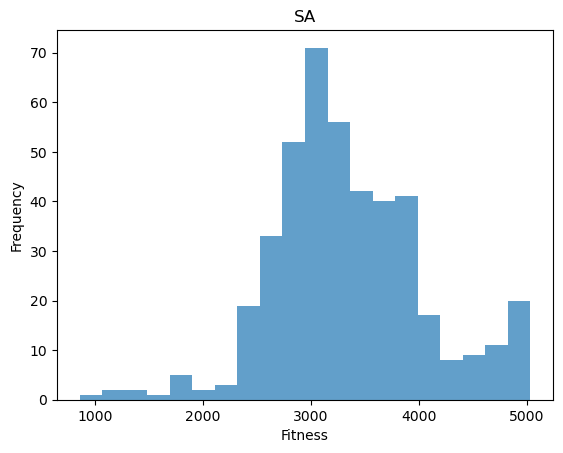

SA fitness: 5036
And it should be: 5246
SA solution:    [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
------------------------------
Test 19:


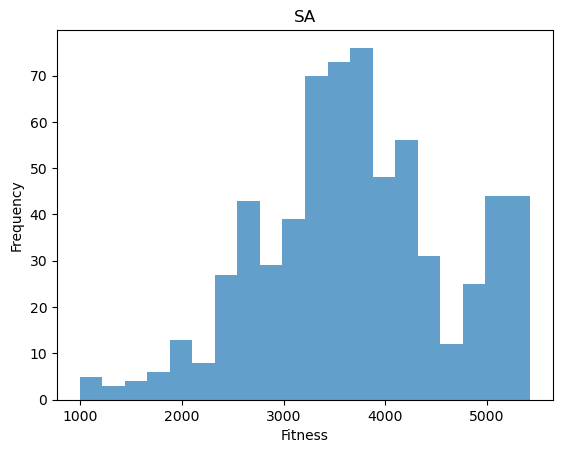

SA fitness: 5428
And it should be: 5605
SA solution:    [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]
------------------------------
Test 20:


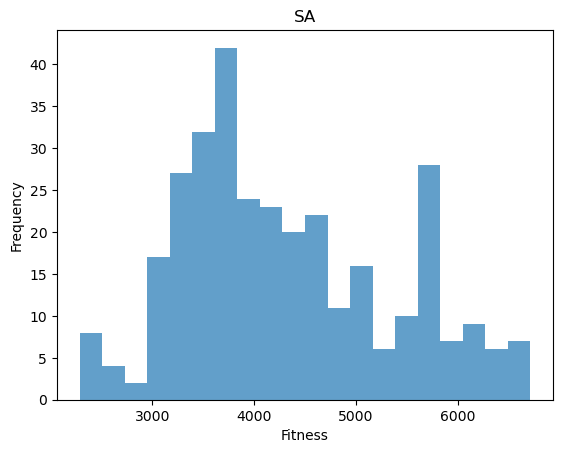

SA fitness: 6710
And it should be: 6954
SA solution:    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
------------------------------


In [52]:
sa_df = pd.DataFrame()

correct_num = 0
for i in range(1, 21):
    A, b, c, optimal_fitness = test(file_path=f"../test_instances/test{i}.txt")
    print(f"Test {i}:")
    start = perf_counter()
    sa_fitness, sa_solution = simulated_annealing(A, b, c, func=1)
    end = perf_counter()

    if sa_fitness == optimal_fitness:
        sa_df.loc[0, f'sa managed to find an optimal solution for test {i}'] = 1
        correct_num += 1
    else:
        sa_df.loc[0, f'sa managed to find an optimal solution for test {i}'] = 0

    sa_df.loc[0, f'test {i} time'] = end - start
    
    print("SA fitness:", sa_fitness)
    print("And it should be:", optimal_fitness)
    print("SA solution:   ", sa_solution)
    print("-" * 30)
sa_df.loc[0, 'number of optimal solutions'] = correct_num

In [53]:
sa_df

,sa managed to find an optimal solution for test 1,test 1 time,sa managed to find an optimal solution for test 2,test 2 time,sa managed to find an optimal solution for test 3,test 3 time,sa managed to find an optimal solution for test 4,test 4 time,sa managed to find an optimal solution for test 5,test 5 time,...,test 16 time,sa managed to find an optimal solution for test 17,test 17 time,sa managed to find an optimal solution for test 18,test 18 time,sa managed to find an optimal solution for test 19,test 19 time,sa managed to find an optimal solution for test 20,test 20 time,number of optimal solutions
0,1.0,0.201667,1.0,0.229127,0.0,0.212112,1.0,0.342828,0.0,0.212077,...,0.167342,0.0,12.126568,0.0,0.165116,0.0,0.325493,0.0,0.21357,4.0


In [54]:
sa_df.to_csv('sa.csv')